In [1]:
!pip install smact
!pip install pymatgen
!pip install denoising_diffusion_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.4/130.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.3/515.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 88.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from google.colab import files
files.upload()

Saving dataset_creation.py to dataset_creation.py
Saving helper_dataset_shuffle.py to helper_dataset_shuffle.py
Saving helper_formula_parse.py to helper_formula_parse.py
Saving helper_reverse_formula.py to helper_reverse_formula.py
Saving helper_unet_functions.py to helper_unet_functions.py
Saving save_valid_compounds_to_csv.py to save_valid_compounds_to_csv.py
Saving smact_validity_checks.py to smact_validity_checks.py
Saving SuperCon_with_types.dat to SuperCon_with_types.dat
Saving supercon_wtypes_parse.py to supercon_wtypes_parse.py
Saving unet1d.py to unet1d.py


{'dataset_creation.py': b'import math\r\nimport numpy as np\r\nimport torch\r\nfrom typing import Tuple\r\nfrom typing import List\r\nimport csv\r\n\r\n# file import\r\nfrom helper_formula_parse import *\r\nfrom supercon_wtypes_parse import *\r\nfrom helper_dataset_shuffle import *\r\nfrom helper_reverse_formula import *\r\n\r\n\r\ndef create_datasets(torch_diffusion_data_raw, USE_VALIDATION_SET = False):\r\n    """\r\n    Creates test and val datasets. Shuffles data as well. Set USE_VALIDATION_SET = False for just shuffling.\r\n    """\r\n    # dataset creation: split train and validation set\r\n    diffusion_raw_size = torch_diffusion_data_raw.size(0)\r\n    if USE_VALIDATION_SET == True:\r\n        TEST_SIZE_FACTOR = 1/6 # ~Same ratio as CIFAR-10\r\n    else:\r\n        TEST_SIZE_FACTOR = 0\r\n    test_diffusion_data_size = math.floor(diffusion_raw_size * TEST_SIZE_FACTOR)\r\n    train_diffusion_data_size = diffusion_raw_size - test_diffusion_data_size\r\n    assert(train_diffusion_

In [4]:
%%time
# Imports:

# defaults
import math
import numpy as np
import matplotlib.pyplot as plt
import csv

# torch stuff
import torch
import torch.nn as nn
from torch.optim import Adam, NAdam
from torch.utils.data import TensorDataset, DataLoader

# UNet dependencies
from denoising_diffusion_pytorch import Unet1D # basic unet for unconditioned
# from functools import partial
# from einops import rearrange, reduce
# from einops.layers.torch import Rearrange

# Smact check dependencies
import smact
from smact.screening import pauling_test
import pandas
import itertools
from fractions import Fraction
import functools
from pymatgen.core.composition import Composition

# Typenotes
from typing import Tuple
from typing import List

# file import
from helper_formula_parse import *
from supercon_wtypes_parse import *
from helper_dataset_shuffle import *
from dataset_creation import *
from helper_reverse_formula import *
# from helper_unet_functions import *
from smact_validity_checks import *
from save_valid_compounds_to_csv import *
# from unet1d import * - own UNet for later Few-shot diffusion

CPU times: user 6.25 ms, sys: 802 µs, total: 7.05 ms
Wall time: 6.78 ms


In [5]:
SUPERCON_DATA_FILE = "SuperCon_with_types.dat"

# element table to set up vectors in R^(1x96): must len(element_table) = 96
element_table = ["H","He","Li","Be","B","C","N","O","F","Ne","Na","Mg","Al","Si","P","S","Cl","Ar","K","Ca","Sc","Ti","V","Cr","Mn","Fe","Co",
              "Ni","Cu","Zn","Ga","Ge","As","Se","Br","Kr","Rb","Sr","Y","Zr","Nb","Mo","Tc","Ru","Rh","Pd","Ag","Cd","In","Sn","Sb","Te",
              "I","Xe","Cs","Ba","La","Ce","Pr","Nd","Pm","Sm","Eu","Gd","Tb","Dy","Ho","Er","Tm","Yb","Lu","Hf","Ta","W","Re","Os","Ir",
              "Pt","Au","Hg","Tl","Pb","Bi","Po","At","Rn","Fr","Ra","Ac","Th","Pa","U","Np","Pu","Am","Cm"]

# validate table correctness
validation_element_table = ["H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca",
                            "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr","Y",
                            "Zr","Nb","Mo","Tc","Ru","Rh","Pd","Ag","Cd","In","Sn","Sb","Te","I","Xe","Cs","Ba","La","Ce","Pr","Nd","Pm",
                            "Sm","Eu","Gd","Tb","Dy","Ho","Er","Tm","Yb","Lu","Hf","Ta","W","Re","Os","Ir","Pt","Au","Hg","Tl","Pb" ,"Bi" ,
                            "Po" ,"At" ,"Rn" ,"Fr" ,"Ra" ,"Ac" ,"Th" ,"Pa" ,"U" ,"Np" ,"Pu" ,"Am" ,"Cm"]

assert(len(element_table) == 96)
print("NOTE: Correct element table length.")

assert(validation_element_table == element_table)
print("NOTE: Valid table.")

NOTE: Correct element table length.
NOTE: Valid table.


In [6]:
_, torch_diffusion_data_raw_cuprates_train, *disregard_other_values = prepare_datasets_for_classes(SUPERCON_DATA_FILE, element_table, return_test_sets = False)

torch.Size([16708, 96])
torch.Size([7589, 96])
torch.Size([1440, 96])
torch.Size([7679, 96])
Train Data Size: 16708 | Test Data Size: 0
Train Data Size: 7589 | Test Data Size: 0
Train Data Size: 1440 | Test Data Size: 0
Train Data Size: 7679 | Test Data Size: 0


In [7]:
print(torch_diffusion_data_raw_cuprates_train.size())

torch.Size([7589, 96])


In [8]:
print(torch_diffusion_data_raw_cuprates_train)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"NOTE: Using Device: \"{device}\"","|",(f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

NOTE: Using Device: "cuda:0" | NVIDIA A100-SXM4-40GB


In [10]:
def get_named_beta_schedule(schedule_name: str, num_diffusion_timesteps: int) -> torch.Tensor:
    """
    Get a pre-defined beta schedule for the given name.

    :param schedule_name: The name of the beta schedule.
    :param num_diffusion_timesteps: The number of diffusion timesteps.
    :return: The beta schedule tensor.
    :rtype: torch.Tensor[torch.float64]
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start, beta_end, num_diffusion_timesteps
        ).to(torch.float64)
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")


In [11]:
def betas_for_alpha_bar(num_diffusion_timesteps: int, alpha_bar: float, max_beta=0.999) -> torch.Tensor:
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumprod of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: The number of betas to produce.
    :param alpha_bar: A lambda that takes an argument t from 0 to 1 and produces
                      the cumulative product of (1-beta) up to that part of the
                      diffusion process.
    :param max_beta: The maximum beta to use; use values lower than 1 to prevent
                     singularities (Improved Diffusion Paper).
    :return: The beta schedule tensor.
    :rtype: torch.Tensor[torch.float64]
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return torch.Tensor(betas).to(torch.float64)


In [12]:
class GaussianDiffusion1D:
    """
    Class for Gaussian diffusion of 1D Tensors (vector diffusion).
    """

    def __init__(
        self,
        sequence_length: int,
        timesteps: int,
        beta_schedule_type: str
    ):
        """
        Initializes the GaussianDiffusion1D class.

        :param sequence_length: Length of the sequence.
        :param timesteps: Number of timesteps.
        :param beta_schedule_type: Type of beta schedule. Can be "linear" or "cosine".

        :raises TypeError: If the beta schedule type is unknown.
        """
        self.sequence_length = sequence_length
        self.timesteps = timesteps
        self.beta_schedule_type = beta_schedule_type

        if self.beta_schedule_type == "linear":
            self.betas = get_named_beta_schedule(self.beta_schedule_type, self.timesteps)
        elif self.beta_schedule_type == "cosine":
            self.betas = get_named_beta_schedule(self.beta_schedule_type, self.timesteps)
        else:
            raise TypeError(f"{self.beta_schedule_type} is an unknown beta schedule type.")

        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, axis=0)

    def forward(
        self,
        x_0: torch.Tensor,
        t: torch.Tensor,
        device: str
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward diffusion process. Adding noise ~ N(0, I) to vectors.

        :param x_0: Original vector of shape (B, C, L).
        :param t: Timestep tensor of shape (B,).
        :param device: Device to be used.

        :return: Tuple containing mean tensor and noise tensor.
        """
        epsilon = torch.randn_like(x_0)
        alphas_bar_t = self.extract(self.alphas_bar, t, x_0.shape)

        mean = torch.sqrt(alphas_bar_t).to(device) * x_0.to(device)
        variance = torch.sqrt((1 - alphas_bar_t)).to(device) * epsilon.to(device)

        return mean + variance, epsilon.to(device)

    @torch.no_grad()
    def backward(
        self,
        x_t: torch.Tensor,
        t: torch.Tensor,
        model: nn.Module,
        **kwargs
    ) -> torch.Tensor:
        """
        Calls the model to predict the noise in the image and returns
        the denoised image (x_{t-1}).

        This method corresponds to the "big for loop" in the sampling algorithm (see algorithm 2 from Ho et al.).

        :param x_t: Current image tensor of shape (B, C, L).
        :param t: Timestep tensor of shape (B,).
        :param model: Model used to predict the noise in the image.
        :param **kwargs: Additional arguments to be passed to the model.

        :return: Denoised image tensor of shape (B, C, L).
        """
        betas_t = self.extract(self.betas, t, x_t.shape)
        sqrt_one_minus_alphas_bar_t = self.extract(torch.sqrt(1. - self.alphas_bar), t, x_t.shape)
        sqrt_recip_alphas_t = self.extract(torch.sqrt(1.0 / self.alphas), t, x_t.shape)
        mean = sqrt_recip_alphas_t * (x_t - ((betas_t / sqrt_one_minus_alphas_bar_t) * model(x_t, t, **kwargs)))
        posterior_variance_t = betas_t

        # Applies noise to this image if we are not in the last step yet.
        if t == 0:
            return mean
        else:
            z = torch.randn_like(x_t)
            variance = torch.sqrt(posterior_variance_t) * z
            return mean + variance

    @staticmethod
    def extract(
        values: torch.Tensor,
        t: torch.Tensor,
        x_0_shape: Tuple[int]
    ) -> torch.Tensor:
        """
        Picks the values from `values` according to the indices stored in `t`.

        :param values: Tensor of values to pick from.
        :param t: Index tensor.
        :param x_0_shape: Shape of the original tensor x_0.

        :return: Reshaped tensor with picked values.
        """
        batch_size = t.shape[0]
        vector_to_reshape = values.gather(-1, t.cpu())
        """
        if len(x_shape) - 1 = 2:
        reshape `out` to dims
        (batch_size, 1, 1)
        """
        return vector_to_reshape.reshape(batch_size, *((1,) * (len(x_0_shape) - 1))).to(t.device)


In [13]:
def plot_noise_distribution(noise: torch.Tensor, predicted_noise: torch.Tensor):
    """
    Plot noise distributions to visualize and compare predicted and ground truth noise.
    """
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

In [14]:
DIFFUSION_TIMESTEPS = 4000
diffusion_model = GaussianDiffusion1D(96, DIFFUSION_TIMESTEPS, "cosine")

In [15]:
# Hyperparameters
BATCH_SIZE = 64
NUM_WORKERS = 24 # TODO: test different values - change much bigger actually uses CPU (change to like 12)
NO_EPOCHS = 100
PRINT_FREQUENCY = 10
LR = 1e-4
VERBOSE = True
USE_VALIDATION_SET = False

In [16]:
diffusion_dataset_train = TensorDataset(torch_diffusion_data_raw_cuprates_train)
train_dataloader = DataLoader(diffusion_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

if USE_VALIDATION_SET == True:
    diffusion_dataset_test = TensorDataset(torch_diffusion_data_raw_cuprates_test)
    test_dataloader = DataLoader(diffusion_dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
unet = Unet1D(
    dim = 48,
    dim_mults = (1, 2, 3, 6),
    channels = 1
)
unet.to(device)

optimizer = torch.optim.NAdam(unet.parameters(), lr=LR)

---
Epoch: 0 | Train Loss 0.2205432695731268


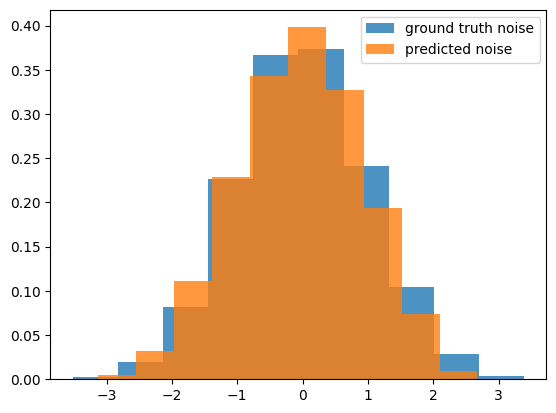

---
Epoch: 9 | Train Loss 0.04248932886363591


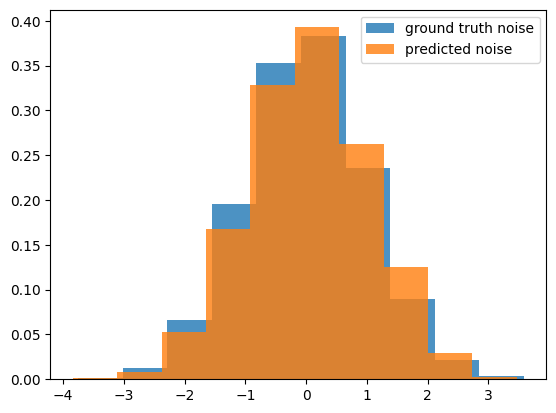

---
Epoch: 19 | Train Loss 0.03404359183258424


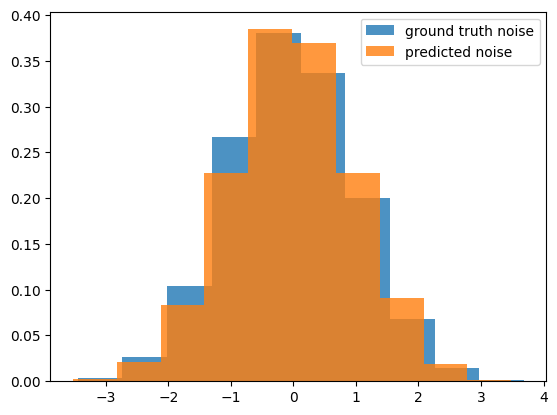

---
Epoch: 29 | Train Loss 0.030368392466235967


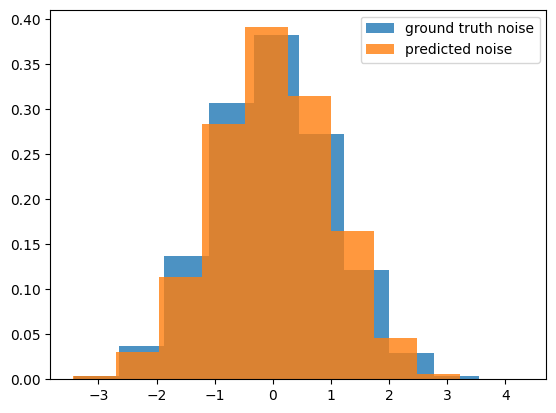

---
Epoch: 39 | Train Loss 0.02871027797207994


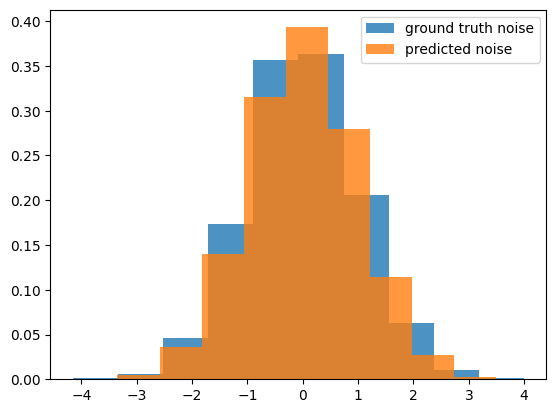

---
Epoch: 49 | Train Loss 0.027033362869110147


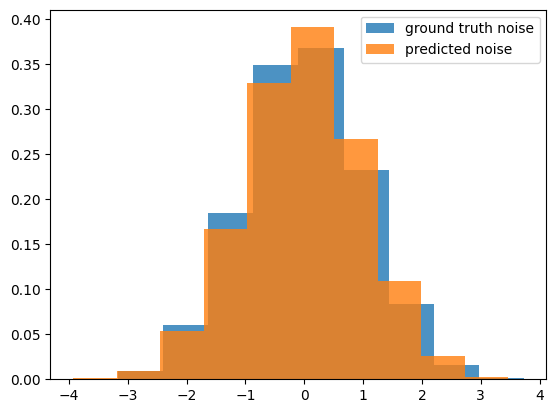

---
Epoch: 59 | Train Loss 0.026740972615652166


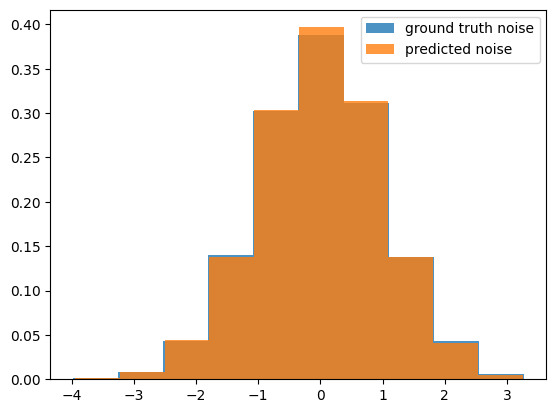

---
Epoch: 69 | Train Loss 0.025961614245454134


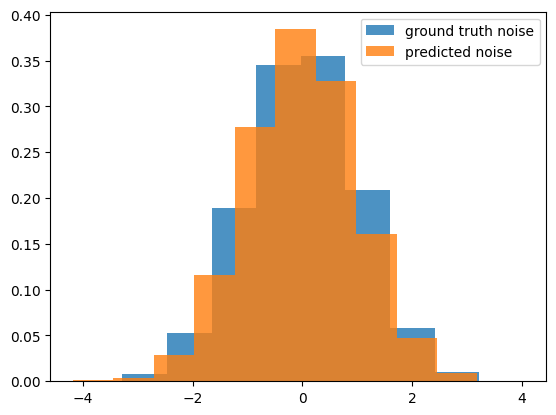

---
Epoch: 79 | Train Loss 0.025828992000828357


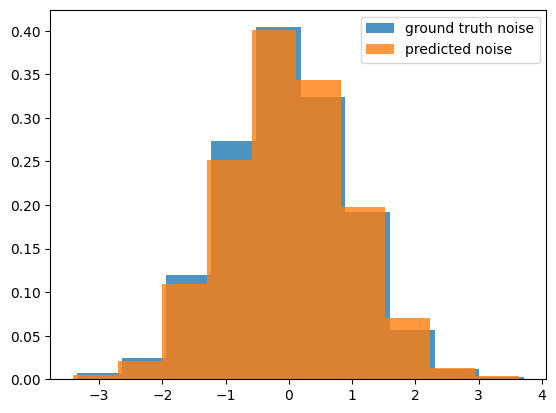

---
Epoch: 89 | Train Loss 0.024499758604471965


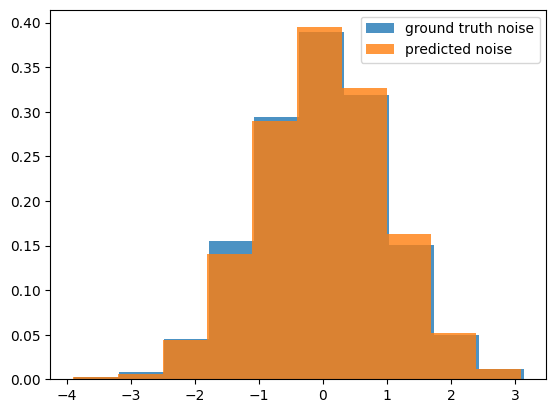

---
Epoch: 99 | Train Loss 0.024866241243494264


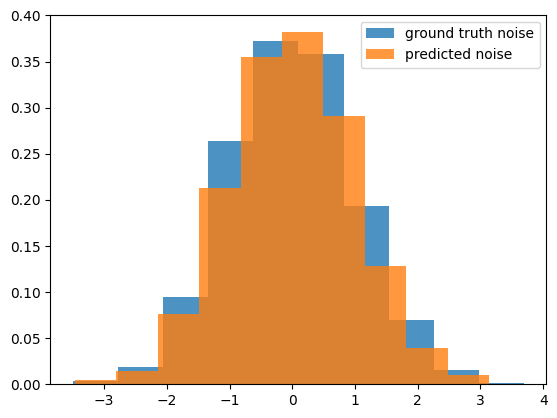

CPU times: user 12min 51s, sys: 1min 59s, total: 14min 51s
Wall time: 14min 56s


In [18]:
%%time
# Training Loop
training_steps_tracker = []
loss_tracker_train = [] # to plot train loss/training step - make sure outside for loop
loss_tracker_val = [] # to plot val loss/training step - make sure outside for loop
epoch_tracker = []
loss_tracker_train_epoch = [] # to plot train loss/epoch - make sure outside for loop
loss_tracker_val_epoch = [] # to plot val loss/epoch - make sure outside for loop
for epoch in range(NO_EPOCHS):
    mean_epoch_loss_train = [] # put in for loop - wipe clean each time
    mean_epoch_loss_val = [] # put in for loop - wipe clean each time

    # on train dataset
    for batch in train_dataloader:
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch_train = batch[0].unsqueeze(1).to(device)

        noisy_batch_train, gt_noise_train = diffusion_model.forward(batch_train, t, device)
        predicted_noise_train = unet(noisy_batch_train.to(torch.float32), t)

        optimizer.zero_grad()
        # loss(pred, target)
        loss = torch.nn.functional.mse_loss(predicted_noise_train, gt_noise_train)
        loss_tracker_train.append(loss.item())
        training_steps_tracker.append(1)
        mean_epoch_loss_train.append(loss.item())
        loss.backward()
        optimizer.step()

    if USE_VALIDATION_SET == True:
        # on test dataset
        for batch in test_dataloader:
            t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
            batch_val = batch[0].unsqueeze(1).to(device)

            noisy_batch_val, gt_noise_val = diffusion_model.forward(batch_val, t, device)
            predicted_noise_val = unet(noisy_batch_val.to(torch.float32), t)

            loss = torch.nn.functional.mse_loss(predicted_noise_val, gt_noise_val)
            loss_tracker_train.append(loss.item())
            mean_epoch_loss_val.append(loss.item())

    epoch_tracker.append(epoch)
    loss_tracker_train_epoch.append(np.mean(mean_epoch_loss_train))
    if USE_VALIDATION_SET == True:
        loss_tracker_val_epoch.append(np.mean(mean_epoch_loss_val))

    # print loss(s)
    if epoch == 0 or epoch % PRINT_FREQUENCY == 9:
        print('---')
        if USE_VALIDATION_SET == True:
            print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss_train)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        else:
            print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss_train)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_distribution(gt_noise_train, predicted_noise_train)
                if USE_VALIDATION_SET == True:
                    plot_noise_distribution(gt_noise_val, predicted_noise_val)

        torch.save(unet.state_dict(), f"unet_param_{epoch}.pth") # save UNet states - use lowest loss UNet for sampling

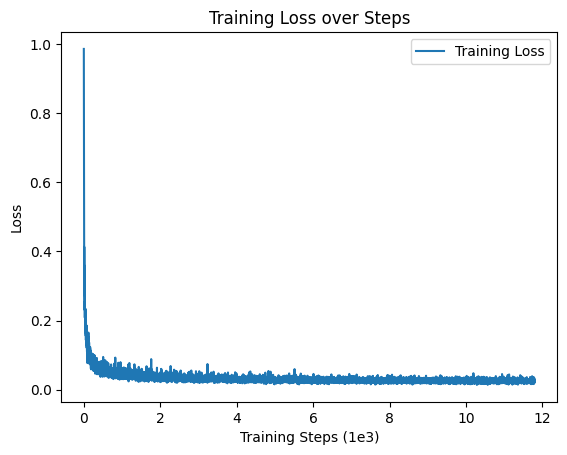

In [23]:
# Plot Loss(s) vs training steps

# Plot and label the training and validation loss values
training_steps_tracker_sum = list(range(len(training_steps_tracker)))  # Convert range to a list
training_steps_tracker_sum = [x/1000 for x in training_steps_tracker_sum]  # Divide each element by 1000

plt.plot(training_steps_tracker_sum, loss_tracker_train, label='Training Loss')
# plt.plot(epochs, loss_tracker_val, label='Validation Loss')
# Add any other required plot configurations (e.g., labels, titles, legends)
plt.xlabel('Training Steps (1e3)')
plt.ylabel('Loss')
plt.title('Training Loss over Steps')
plt.legend()
plt.show()


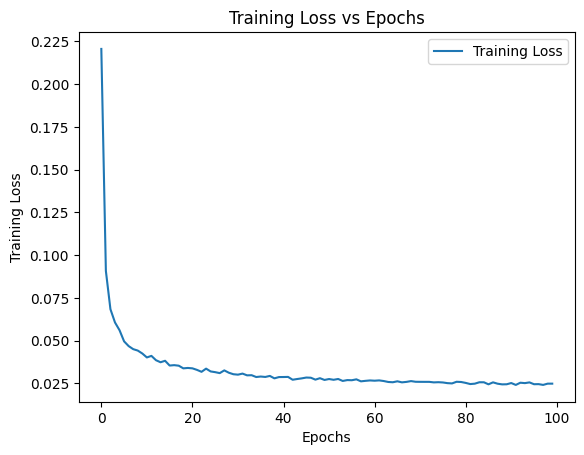

In [24]:
# Plot Loss(s) vs epochs

# Plot and label the training and validation loss values
plt.plot(epoch_tracker, loss_tracker_train_epoch, label='Training Loss')
# plt.plot(epochs, loss_tracker_val, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

# Set the tick locations
# plt.xticks(arange(0, len(loss_tracker_train) + 1, 100))

# # Display the plot
plt.legend(loc='best')
plt.show()

In [29]:
NUM_SAMPLE_VECTORS = 5000
VERBOSE_SAMPLING = True

In [30]:
%%time
# torch.manual_seed(16) # for replication

with torch.no_grad():
    vectors = torch.randn(NUM_SAMPLE_VECTORS, 1, diffusion_model.sequence_length).to(device)
    print(vectors.size())
    """
    Sampling Algorithm (Algorithm 2 from Ho et al.).

    "taking noise and turning into good stuff"
    """
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        vectors = diffusion_model.backward(vectors.to(torch.float32), t, unet.eval().to(device))
        if (VERBOSE_SAMPLING == True) and (i % 50 == 49 or i == diffusion_model.timesteps - 1):
            print(f"t = {i}")
            # print(torch.round(vectors[0], decimals = 2))
            # torch.set_printoptions(precision=2)
        if i == 0:
            print("t = 0")
            print("Sampling Complete.")

torch.Size([5000, 1, 96])
t = 3999
t = 3949
t = 3899
t = 3849
t = 3799
t = 3749
t = 3699
t = 3649
t = 3599
t = 3549
t = 3499
t = 3449
t = 3399
t = 3349
t = 3299
t = 3249
t = 3199
t = 3149
t = 3099
t = 3049
t = 2999
t = 2949
t = 2899
t = 2849
t = 2799
t = 2749
t = 2699
t = 2649
t = 2599
t = 2549
t = 2499
t = 2449
t = 2399
t = 2349
t = 2299
t = 2249
t = 2199
t = 2149
t = 2099
t = 2049
t = 1999
t = 1949
t = 1899
t = 1849
t = 1799
t = 1749
t = 1699
t = 1649
t = 1599
t = 1549
t = 1499
t = 1449
t = 1399
t = 1349
t = 1299
t = 1249
t = 1199
t = 1149
t = 1099
t = 1049
t = 999
t = 949
t = 899
t = 849
t = 799
t = 749
t = 699
t = 649
t = 599
t = 549
t = 499
t = 449
t = 399
t = 349
t = 299
t = 249
t = 199
t = 149
t = 99
t = 49
t = 0
Sampling Complete.
CPU times: user 10min 4s, sys: 717 ms, total: 10min 4s
Wall time: 8min 14s


In [31]:
SHOW_FAULTY_GENERATIONS = False
VERBOSE_GENERATION_PRINTING = False
faulty_sample_count = []
generated_superconductors_raw = []
for i in range(NUM_SAMPLE_VECTORS):
    raw_generated_vector = torch.round(vectors[i], decimals = 2)
    raw_generated_vector = raw_generated_vector[0]

    """
    Apply threshold filter to remove residual noise.
    """
    # TODO: refine threshold method
    filtered_generated_vector = raw_generated_vector
    threshold = 0.1# Threshold value - keep between (0.01, 0.1)
    mask = torch.abs(filtered_generated_vector) < threshold # Create a mask for values that satisfy the condition
    filtered_generated_vector[mask] = 0.00 # Apply the mask to set the values to 0.00

    torch.set_printoptions(precision=2)

    """
    Get rid of result if has negative element values <-0.1. Too much noise.
    """
    # TODO: if samples with neg values are very noise, examine training process, change timesteps and epochs.
    negative_values_mask = filtered_generated_vector < 0.0 # after mask
    if (True not in negative_values_mask) and (torch.count_nonzero(filtered_generated_vector) > 1):
        sample_faulty = False
        generated_cform = cform_from_vector(filtered_generated_vector, element_table)
        if VERBOSE_GENERATION_PRINTING == True:
            print(generated_cform)
        generated_superconductors_raw.append(generated_cform)
    else:
        sample_faulty = True
        faulty_sample_count.append(1)
        if SHOW_FAULTY_GENERATIONS == True:
            generated_cform = cform_from_vector(filtered_generated_vector, element_table)
            print(f"Faulty Generation: {generated_cform}")

print(f"Excluded {len(faulty_sample_count)} faulty samples.")

Excluded 3765 faulty samples.


In [32]:
generated_superconductors_raw = np.array(generated_superconductors_raw)

In [33]:
generated_superconductors_vector_formulas = []
for i in range(np.size(generated_superconductors_raw)):
    split_formula_char = split_scform_to_char(generated_superconductors_raw[i])
    merge_formula_char = merge_sc_char(split_formula_char)
    vector_formula = split_sc_to_vector(merge_formula_char, element_table)
    generated_superconductors_vector_formulas.append(vector_formula)

In [34]:
generated_superconductors_vector_formulas = np.array(generated_superconductors_vector_formulas)

In [37]:
# uniqueness and novelty test
# find overlap between training data and generated data
overlap = []
for vec1 in generated_superconductors_vector_formulas:
    for vec2 in torch_diffusion_data_raw_cuprates_train.numpy():
        if np.all(np.equal(vec1, vec2)):
            overlap.append(vec1)

overlap = np.array(overlap)

# Find repeating vectors and their counts
unique_vectors, counts = np.unique(generated_superconductors_vector_formulas, axis=0, return_counts=True)

# Get the repeating vectors
repeating_vectors = unique_vectors[counts > 1]

print("Overlapping Vectors:")
print(overlap)
print("Repeating Vectors:")
print(repeating_vectors)

Overlapping Vectors:
[]
Repeating Vectors:
[]


In [38]:
valid_generated_compounds, valid_generated_compounds_size = filter_for_valid_generated_compounds(generated_superconductors_raw)

/usr/local/lib/python3.10/dist-packages/pymatgen/core/periodic_table.py:221: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymatgen/core/periodic_table.py:221: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


92


In [39]:
OUTPUT_FILE = "output_generated_superconductors_5.csv"
store_valid_to_csv(valid_generated_compounds, OUTPUT_FILE)

Array has been successfully saved to CSV file.
